In [1]:
!pip install --upgrade pip
!pip install imblearn
!pip install xgboost
import warnings
warnings.filterwarnings('ignore')

import s3fs
import pickle as pkl
import tarfile
import xgboost
import io
import os
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np 
import pandas as pd 
import boto3
import sagemaker
from scipy.stats                       import ks_2samp
from sklearn.metrics                   import confusion_matrix, auc, roc_curve, recall_score,accuracy_score, precision_score, roc_auc_score, precision_recall_curve, average_precision_score, f1_score
from sagemaker.amazon.amazon_estimator import get_image_uri
from time                              import gmtime, strftime, sleep
from sagemaker                         import get_execution_role
from sklearn.model_selection           import train_test_split
from imblearn.over_sampling            import SMOTE
%matplotlib inline


Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (20.2.3)


In [2]:
# in this cell is all the import information for the all rest of code.
# all informations about Sagemaker.
sagemaker_session = sagemaker.Session()
region            = boto3.Session().region_name
smclient          = boto3.Session().client('sagemaker')
role              = sagemaker.get_execution_role()
bucket            = sagemaker_session.default_bucket()

In [3]:
# import dataset only
base_raiz = pd.DataFrame(pd.read_csv('TB_TBN_SISCAN_HISTO_MAMA_PACNT.csv',
                                    sep = ';'))

In [4]:
base_raiz.columns

Index(['CO_SEQ_SISCAN_HISTO_MAMA_PACNT', 'CO_UF_RESIDENCIA',
       'CO_MUN_RESIDENCIA', 'NU_ANO_COMPETENCIA', 'NU_ANO_MES_COMPETENCIA',
       'CO_RACA_COR', 'CO_IDADE_PACIENTE', 'CO_ESCOLARIDADE',
       'CO_INTERVALO_COLETA', 'CO_INTERVALO_EXAME', 'CO_TEMPO_EXAME',
       'TP_RISCO_ELEVADO', 'TP_EXAME_HISTOPATOLOGICO', 'TP_DETECCAO_LESAO',
       'TP_LATERALIDADE_LESAO', 'TP_TAMANHO_LESAO',
       'TP_LINFONODO_AXILAR_PALPAVEL', 'TP_MATER_ENVIA_PROCEDENTE',
       'TP_PROCEDIMENTO_CIRURGICO', 'TP_ADEQUABILIDAD_MATERIAL',
       'ST_MICROCALCIFICACAO', 'TP_LESAO', 'TP_LESAO_CARAT_NEOPL_MALI',
       'TP_GRAU_HISTOLOGICO', 'TP_MARGEM_CIRURGICA', 'CO_PACIENTE', 'SG_SEXO',
       'TP_DIAGNOSTICO_IMAGEM', 'TP_TAMANHO_TUMOR', 'CO_ANO_RESULTADO',
       'TP_LAUDO_HISTOPATOLOGICO', 'SG_UF_RESIDENCIA'],
      dtype='object')

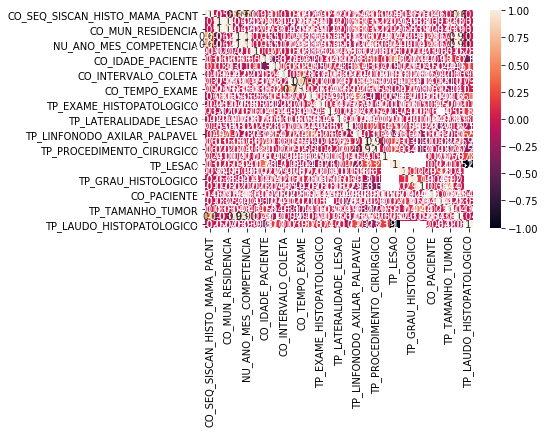

In [5]:
# I make a correltion matrix only for visual help.
corrMatrix = base_raiz.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [7]:
corr_matrix = base_raiz.corr().abs()
upper       = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop     = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['CO_MUN_RESIDENCIA', 'NU_ANO_MES_COMPETENCIA', 'TP_LAUDO_HISTOPATOLOGICO']

In [8]:
# drop time.
# this column I not use on the problem.
base_raiz.drop(columns ={'NU_ANO_COMPETENCIA', 
                         'NU_ANO_MES_COMPETENCIA', 
                         'CO_TEMPO_EXAME', 
                         'TP_EXAME_HISTOPATOLOGICO', 
                         'TP_MATER_ENVIA_PROCEDENTE', 
                         'TP_PROCEDIMENTO_CIRURGICO',
                         'TP_ADEQUABILIDAD_MATERIAL',
                         'CO_ANO_RESULTADO', 
                         'TP_LESAO_CARAT_NEOPL_MALI', 
                         'TP_GRAU_HISTOLOGICO', 
                         'TP_MARGEM_CIRURGICA', 
                         'TP_DIAGNOSTICO_IMAGEM', 
                         'TP_LESAO',
                         'CO_PACIENTE'},
               inplace = True)
base_raiz = base_raiz.select_dtypes(exclude=['object'])
base_raiz.columns

Index(['CO_SEQ_SISCAN_HISTO_MAMA_PACNT', 'CO_UF_RESIDENCIA',
       'CO_MUN_RESIDENCIA', 'CO_RACA_COR', 'CO_IDADE_PACIENTE',
       'CO_ESCOLARIDADE', 'CO_INTERVALO_COLETA', 'CO_INTERVALO_EXAME',
       'TP_RISCO_ELEVADO', 'TP_DETECCAO_LESAO', 'TP_LATERALIDADE_LESAO',
       'TP_TAMANHO_LESAO', 'TP_LINFONODO_AXILAR_PALPAVEL', 'TP_TAMANHO_TUMOR',
       'TP_LAUDO_HISTOPATOLOGICO'],
      dtype='object')

In [11]:
base_raiz.groupby('TP_LAUDO_HISTOPATOLOGICO').count()

,CO_SEQ_SISCAN_HISTO_MAMA_PACNT,CO_UF_RESIDENCIA,CO_MUN_RESIDENCIA,CO_RACA_COR,CO_IDADE_PACIENTE,CO_ESCOLARIDADE,CO_INTERVALO_COLETA,CO_INTERVALO_EXAME,TP_RISCO_ELEVADO,TP_DETECCAO_LESAO,TP_LATERALIDADE_LESAO,TP_TAMANHO_LESAO,TP_LINFONODO_AXILAR_PALPAVEL,TP_TAMANHO_TUMOR
TP_LAUDO_HISTOPATOLOGICO,,,,,,,,,,,,,,
1,50127,50127,50127,50127,50127,420,50126,50127,50127,50127,50127,50127,50127,50127
2,1922,1922,1922,1922,1922,2,1922,1922,1922,1922,1922,1922,1922,1922
3,665,665,665,665,665,2,665,665,665,665,665,665,665,665
4,76821,76821,76821,76821,76821,223,76819,76821,76821,76821,76821,76821,76821,76821
6,1062,1062,1062,1062,1062,7,1062,1062,1062,1062,1062,1062,1062,1062


In [12]:
#shuffle dataframe
base_raiz = base_raiz.sample(frac = 1)
Y_column  = base_raiz['TP_LAUDO_HISTOPATOLOGICO']
X_columns = base_raiz.drop(columns = 'TP_LAUDO_HISTOPATOLOGICO')

#prepare the test out-of-time base:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_columns,
                                                            Y_column, 
                                                            test_size    = 0.15, 
                                                            random_state = 666)
base_treino_val = pd.concat([X_train_val, Y_train_val], axis = 1)
base_treino_val.columns

Index(['CO_SEQ_SISCAN_HISTO_MAMA_PACNT', 'CO_UF_RESIDENCIA',
       'CO_MUN_RESIDENCIA', 'CO_RACA_COR', 'CO_IDADE_PACIENTE',
       'CO_ESCOLARIDADE', 'CO_INTERVALO_COLETA', 'CO_INTERVALO_EXAME',
       'TP_RISCO_ELEVADO', 'TP_DETECCAO_LESAO', 'TP_LATERALIDADE_LESAO',
       'TP_TAMANHO_LESAO', 'TP_LINFONODO_AXILAR_PALPAVEL', 'TP_TAMANHO_TUMOR',
       'TP_LAUDO_HISTOPATOLOGICO'],
      dtype='object')

## CORRIGE NAN NA BASE DE TREINO & VALIDAÇÃO

In [13]:
column_means    = base_treino_val.mean()
base_treino_val = base_treino_val.fillna(column_means)
base_treino_val.sample(1)

,CO_SEQ_SISCAN_HISTO_MAMA_PACNT,CO_UF_RESIDENCIA,CO_MUN_RESIDENCIA,CO_RACA_COR,CO_IDADE_PACIENTE,CO_ESCOLARIDADE,CO_INTERVALO_COLETA,CO_INTERVALO_EXAME,TP_RISCO_ELEVADO,TP_DETECCAO_LESAO,TP_LATERALIDADE_LESAO,TP_TAMANHO_LESAO,TP_LINFONODO_AXILAR_PALPAVEL,TP_TAMANHO_TUMOR,TP_LAUDO_HISTOPATOLOGICO
14643,47889,25,250905,5,24,2.807487,1.0,4,2,2,1,2,2,5,4


## CORRIGE NAN NA BASE DE TESTE

In [14]:
base_teste              = pd.concat([X_test, Y_test], axis = 1)
base_teste              = base_teste.sample(frac = 1)
column_means            = base_teste.mean()
base_teste              = base_teste.fillna(column_means)
base_teste['flag_raiz'] = np.where(base_teste['TP_LAUDO_HISTOPATOLOGICO'] == 1, 0,
                          np.where(base_teste['TP_LAUDO_HISTOPATOLOGICO'] == 2, 1,
                          np.where(base_teste['TP_LAUDO_HISTOPATOLOGICO'] == 3, 2,
                          np.where(base_teste['TP_LAUDO_HISTOPATOLOGICO'] == 4, 3, 4))))
base_teste.drop(columns = 'TP_LAUDO_HISTOPATOLOGICO',
                inplace = True)

X_test = pd.DataFrame(base_teste.drop(columns = 'flag_raiz'))
Y_test = pd.DataFrame(base_teste['flag_raiz'])

In [15]:
X_test.sample(2)

,CO_SEQ_SISCAN_HISTO_MAMA_PACNT,CO_UF_RESIDENCIA,CO_MUN_RESIDENCIA,CO_RACA_COR,CO_IDADE_PACIENTE,CO_ESCOLARIDADE,CO_INTERVALO_COLETA,CO_INTERVALO_EXAME,TP_RISCO_ELEVADO,TP_DETECCAO_LESAO,TP_LATERALIDADE_LESAO,TP_TAMANHO_LESAO,TP_LINFONODO_AXILAR_PALPAVEL,TP_TAMANHO_TUMOR
127908,366349,53,530010,3,44,2.784946,1.0,1,2,1,1,3,1,5
128726,369684,25,251570,3,61,2.784946,1.0,2,2,2,2,2,2,5


In [16]:
Y_test

,flag_raiz
95389,3
32008,0
31790,0
93633,3
31784,3
...,...
6407,3
17590,3
114107,0
88035,0


## PREPARA BASE DE TREINO E VALIDAÇÃO

In [17]:
base_treino_val.groupby('TP_LAUDO_HISTOPATOLOGICO').count()

,CO_SEQ_SISCAN_HISTO_MAMA_PACNT,CO_UF_RESIDENCIA,CO_MUN_RESIDENCIA,CO_RACA_COR,CO_IDADE_PACIENTE,CO_ESCOLARIDADE,CO_INTERVALO_COLETA,CO_INTERVALO_EXAME,TP_RISCO_ELEVADO,TP_DETECCAO_LESAO,TP_LATERALIDADE_LESAO,TP_TAMANHO_LESAO,TP_LINFONODO_AXILAR_PALPAVEL,TP_TAMANHO_TUMOR
TP_LAUDO_HISTOPATOLOGICO,,,,,,,,,,,,,,
1,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701
2,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643
3,564,564,564,564,564,564,564,564,564,564,564,564,564,564
4,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186
6,913,913,913,913,913,913,913,913,913,913,913,913,913,913


In [18]:
base_treino_val['flag_2'] = np.where(base_treino_val['TP_LAUDO_HISTOPATOLOGICO'] == 2, 1, 0)
base_treino_val['flag_3'] = np.where(base_treino_val['TP_LAUDO_HISTOPATOLOGICO'] == 3, 1, 0)
base_treino_val['flag_6'] = np.where(base_treino_val['TP_LAUDO_HISTOPATOLOGICO'] == 6, 1, 0)
base_treino_val.columns

Index(['CO_SEQ_SISCAN_HISTO_MAMA_PACNT', 'CO_UF_RESIDENCIA',
       'CO_MUN_RESIDENCIA', 'CO_RACA_COR', 'CO_IDADE_PACIENTE',
       'CO_ESCOLARIDADE', 'CO_INTERVALO_COLETA', 'CO_INTERVALO_EXAME',
       'TP_RISCO_ELEVADO', 'TP_DETECCAO_LESAO', 'TP_LATERALIDADE_LESAO',
       'TP_TAMANHO_LESAO', 'TP_LINFONODO_AXILAR_PALPAVEL', 'TP_TAMANHO_TUMOR',
       'TP_LAUDO_HISTOPATOLOGICO', 'flag_2', 'flag_3', 'flag_6'],
      dtype='object')

In [19]:
from collections import Counter
smote = SMOTE(sampling_strategy = 0.05,
              random_state = 666)
X_raiz, Y_raiz = smote.fit_sample(base_treino_val.drop(columns='flag_2'), base_treino_val['flag_2'])
base_treino_val = X_raiz
base_treino_val.groupby('TP_LAUDO_HISTOPATOLOGICO').count()

,CO_SEQ_SISCAN_HISTO_MAMA_PACNT,CO_UF_RESIDENCIA,CO_MUN_RESIDENCIA,CO_RACA_COR,CO_IDADE_PACIENTE,CO_ESCOLARIDADE,CO_INTERVALO_COLETA,CO_INTERVALO_EXAME,TP_RISCO_ELEVADO,TP_DETECCAO_LESAO,TP_LATERALIDADE_LESAO,TP_TAMANHO_LESAO,TP_LINFONODO_AXILAR_PALPAVEL,TP_TAMANHO_TUMOR,flag_3,flag_6
TP_LAUDO_HISTOPATOLOGICO,,,,,,,,,,,,,,,,
1,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701
2,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468
3,564,564,564,564,564,564,564,564,564,564,564,564,564,564,564,564
4,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186
6,913,913,913,913,913,913,913,913,913,913,913,913,913,913,913,913


In [20]:
from collections import Counter
smote = SMOTE(sampling_strategy = 0.03,
              random_state = 666)
X_raiz, Y_raiz = smote.fit_sample(base_treino_val.drop(columns='flag_3'), base_treino_val['flag_3'])
base_treino_val = X_raiz
base_treino_val.groupby('TP_LAUDO_HISTOPATOLOGICO').count()

,CO_SEQ_SISCAN_HISTO_MAMA_PACNT,CO_UF_RESIDENCIA,CO_MUN_RESIDENCIA,CO_RACA_COR,CO_IDADE_PACIENTE,CO_ESCOLARIDADE,CO_INTERVALO_COLETA,CO_INTERVALO_EXAME,TP_RISCO_ELEVADO,TP_DETECCAO_LESAO,TP_LATERALIDADE_LESAO,TP_TAMANHO_LESAO,TP_LINFONODO_AXILAR_PALPAVEL,TP_TAMANHO_TUMOR,flag_6
TP_LAUDO_HISTOPATOLOGICO,,,,,,,,,,,,,,,
1,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701
2,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468
3,3428,3428,3428,3428,3428,3428,3428,3428,3428,3428,3428,3428,3428,3428,3428
4,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186
6,913,913,913,913,913,913,913,913,913,913,913,913,913,913,913


In [21]:
from collections import Counter
smote = SMOTE(sampling_strategy = 0.05,
              random_state = 666)
X_raiz, Y_raiz = smote.fit_sample(base_treino_val.drop(columns='flag_6'), base_treino_val['flag_6'])
base_treino_val = X_raiz
base_treino_val.groupby('TP_LAUDO_HISTOPATOLOGICO').count()

,CO_SEQ_SISCAN_HISTO_MAMA_PACNT,CO_UF_RESIDENCIA,CO_MUN_RESIDENCIA,CO_RACA_COR,CO_IDADE_PACIENTE,CO_ESCOLARIDADE,CO_INTERVALO_COLETA,CO_INTERVALO_EXAME,TP_RISCO_ELEVADO,TP_DETECCAO_LESAO,TP_LATERALIDADE_LESAO,TP_TAMANHO_LESAO,TP_LINFONODO_AXILAR_PALPAVEL,TP_TAMANHO_TUMOR
TP_LAUDO_HISTOPATOLOGICO,,,,,,,,,,,,,,
1,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701
2,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468
3,3428,3428,3428,3428,3428,3428,3428,3428,3428,3428,3428,3428,3428,3428
4,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186
6,5839,5839,5839,5839,5839,5839,5839,5839,5839,5839,5839,5839,5839,5839


In [22]:
base_treino_val['flag_raiz'] = np.where(base_treino_val['TP_LAUDO_HISTOPATOLOGICO'] == 1, 0,
                               np.where(base_treino_val['TP_LAUDO_HISTOPATOLOGICO'] == 2, 1,
                               np.where(base_treino_val['TP_LAUDO_HISTOPATOLOGICO'] == 3, 2,
                               np.where(base_treino_val['TP_LAUDO_HISTOPATOLOGICO'] == 4, 3, 4))))
base_treino_val.drop(columns = 'TP_LAUDO_HISTOPATOLOGICO',
               inplace = True)
base_treino_val.groupby('flag_raiz').count()

,CO_SEQ_SISCAN_HISTO_MAMA_PACNT,CO_UF_RESIDENCIA,CO_MUN_RESIDENCIA,CO_RACA_COR,CO_IDADE_PACIENTE,CO_ESCOLARIDADE,CO_INTERVALO_COLETA,CO_INTERVALO_EXAME,TP_RISCO_ELEVADO,TP_DETECCAO_LESAO,TP_LATERALIDADE_LESAO,TP_TAMANHO_LESAO,TP_LINFONODO_AXILAR_PALPAVEL,TP_TAMANHO_TUMOR
flag_raiz,,,,,,,,,,,,,,
0,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701,42701
1,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468,5468
2,3428,3428,3428,3428,3428,3428,3428,3428,3428,3428,3428,3428,3428,3428
3,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186,65186
4,5839,5839,5839,5839,5839,5839,5839,5839,5839,5839,5839,5839,5839,5839


In [23]:
base_treino_val = base_treino_val.sample(frac = 1)
Y_column        = base_treino_val['flag_raiz']
X_columns       = base_treino_val.drop(columns = 'flag_raiz')

X_train, X_val, Y_train, Y_val           = train_test_split(X_columns,
                                                            Y_column, 
                                                            test_size    = 0.3, 
                                                            random_state = 666)
Y_train = pd.DataFrame(Y_train)
X_train = pd.DataFrame(X_train)
Y_val   = pd.DataFrame(Y_val)
X_val   = pd.DataFrame(X_val)

## INICIA PROCESSO DE TREINAMENTO

In [24]:
data_directory = 'histo_detection'
prefix_model   = 'model'
prefix_other   = 'predict'
prefix_tuning  = 'SGM - Output Hyper.Tun'

if not os.path.exists(data_directory):
        os.makedirs(data_directory)
        
pd.DataFrame(X_test).to_csv(os.path.join(data_directory, 'test_X.csv'), header=False, index=False)
pd.DataFrame(Y_test).to_csv(os.path.join(data_directory, 'test_Y.csv'), header=False, index=False)

pd.DataFrame(X_train).to_csv(os.path.join(data_directory, 'train_X.csv'), header=False, index=False)
pd.DataFrame(X_val).to_csv(os.path.join(data_directory, 'val_X.csv'), header=False, index=False)

pd.concat([Y_val  , X_val]  , axis=1).to_csv(os.path.join(data_directory, 'valid.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_directory, 'train.csv'), header=False, index=False)

In [25]:
# upload all data to S3
train_loc   = sagemaker_session.upload_data(os.path.join(data_directory, 'train.csv'), key_prefix=prefix_model)
train_X_loc = sagemaker_session.upload_data(os.path.join(data_directory, 'train_X.csv'), key_prefix=prefix_other)

valid_loc   = sagemaker_session.upload_data(os.path.join(data_directory, 'valid.csv'), key_prefix=prefix_model)
valid_X_loc = sagemaker_session.upload_data(os.path.join(data_directory, 'val_X.csv'), key_prefix=prefix_other)

test_X_loc  = sagemaker_session.upload_data(os.path.join(data_directory, 'test_X.csv'), key_prefix=prefix_other)
test_Y_loc  = sagemaker_session.upload_data(os.path.join(data_directory, 'test_Y.csv'), key_prefix=prefix_other)

In [28]:
tuning_job_name = 'xgboost-tuningjob-' + strftime("%d-%H-%M-%S", gmtime())
print (tuning_job_name)
tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "0.5",
          "MinValue": "0",
          "Name": "eta",
        },
        {
          "MaxValue": "5",
          "MinValue": "0",
          "Name": "gamma",
        },
        {
          "MaxValue": "50",
          "MinValue": "0",
          "Name": "min_child_weight",
        },
        {
          "MaxValue": "50",
          "MinValue": "0",
          "Name": "alpha",
        },
        {
          "MaxValue": "1",
          "MinValue": "0.5",
          "Name": "subsample",            
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "6",
          "MinValue": "1",
          "Name": "max_depth",
        },
        {
          "MaxValue": "1000",
          "MinValue": "100",
          "Name": "num_round",
        },
        {
          "MaxValue": "10",
          "MinValue": "0",
          "Name": "max_delta_step",
        },
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 36,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:merror",
      "Type": "Minimize"
    }
  }

xgboost-tuningjob-13-17-13-25


In [29]:
training_image = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='latest')
     
s3_input_train = 's3://{}/{}/train'.format(bucket, prefix_model)
s3_input_validation ='s3://{}/{}/valid'.format(bucket, prefix_model)

training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": training_image,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_train
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_validation
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}/{}/output".format(bucket,prefix_tuning)
    },
    "ResourceConfig": {
      "InstanceCount": 1,
      "InstanceType": "ml.m4.xlarge",
      "VolumeSizeInGB": 20
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "merror",
      "objective": "multi:softprob",
      "num_class" : '5',
      "seed" : "666"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [30]:
smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                           HyperParameterTuningJobConfig = tuning_job_config,
                                           TrainingJobDefinition = training_job_definition)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:771330539858:hyper-parameter-tuning-job/xgboost-tuningjob-13-17-13-25',
 'ResponseMetadata': {'RequestId': 'c0223d8e-5c85-4a98-91ac-89cfcf662c75',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c0223d8e-5c85-4a98-91ac-89cfcf662c75',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '130',
   'date': 'Sun, 13 Sep 2020 17:13:30 GMT'},
  'RetryAttempts': 0}}

In [33]:
smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name)['HyperParameterTuningJobStatus']

'Completed'

In [35]:
container = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='latest')

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix_model), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/valid'.format(bucket, prefix_model), content_type='csv')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [52]:
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix_model),
                                    sagemaker_session=sagemaker_session)
#after run the hiperparameter tunning I catch the best model from AWS Sagemaker View

xgb.set_hyperparameters(max_depth        = 6,
                        alpha            = 1.3590152328600276,
                        max_delta_step   = 6,
                        min_child_weight = 1.8323029919604323,
                        subsample        = 0.9891388904541443,
                        eta              = 0.4258935309521509,
                        gamma            = 0.3573669255797674,
                        num_round        = 27,#194
                        seed             = 666,
                        silent           = 0,
                        num_class        = 5,
                        objective        = 'multi:softprob',
                        eval_metric      = 'merror')

xgb.fit({'train': s3_input_train, 
         'validation': s3_input_validation}) 


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-09-13 19:02:30 Starting - Starting the training job...
2020-09-13 19:02:32 Starting - Launching requested ML instances.........
2020-09-13 19:04:02 Starting - Preparing the instances for training......
2020-09-13 19:05:03 Downloading - Downloading input data...
2020-09-13 19:05:57 Training - Training image download completed. Training in progress..Arguments: train
[2020-09-13:19:05:58:INFO] Running standalone xgboost training.
[2020-09-13:19:05:58:INFO] File size need to be processed in the node: 7.0mb. Available memory size in the node: 8483.86mb
[2020-09-13:19:05:58:INFO] Determined delimiter of CSV input is ','
[19:05:58] S3DistributionType set as FullyReplicated
[19:05:58] 85835x14 matrix with 1201690 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-09-13:19:05:58:INFO] Determined delimiter of CSV input is ','
[19:05:58] S3DistributionType set as FullyReplicated
[19:05:58] 36787x14 matrix with 515018 entries loaded from /opt/ml/input/dat

# PREDICTION AND RESULTS

## BATCH TRANSFORM

To analyse if the model is good I use an endpoint on batch transform mode in the three datasets:

1) training dataset (endpoint batch transform mode - after put the information of prediction on local directory)

2) validation dataset (endpoint batch transform mode - after put the information of prediction on local directory)

3) test dataset (endpoint batch transform mode - after put the information of prediction on local directory)

In [53]:
xgb_transformer = xgb.transformer(instance_count = 1, 
                                  instance_type = 'ml.m4.xlarge')
xgb_transformer.transform(train_X_loc, 
                          content_type='text/csv', 
                          split_type='Line')
xgb_transformer.wait()

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


............................2020-09-13T19:11:40.654:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Arguments: serve
[2020-09-13 19:11:40 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-09-13 19:11:40 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-09-13 19:11:40 +0000] [1] [INFO] Using worker: gevent
[2020-09-13 19:11:40 +0000] [37] [INFO] Booting worker with pid: 37
[2020-09-13 19:11:40 +0000] [38] [INFO] Booting worker with pid: 38
[2020-09-13:19:11:40:INFO] Model loaded successfully for worker : 37
Arguments: serve
[2020-09-13 19:11:40 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-09-13 19:11:40 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-09-13 19:11:40 +0000] [1] [INFO] Using worker: gevent
[2020-09-13 19:11:40 +0000] [37] [INFO] Booting worker with pid: 37
[2020-09-13 19:11:40 +0000] [38] [INFO] Booting worker with pid: 38
[2020-09-13:19:11:40:INFO] Model loaded successfully for worker : 37
[2020-09-13 

In [54]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_directory

download: s3://sagemaker-us-east-1-771330539858/xgboost-2020-09-13-19-07-09-714/train_X.csv.out to histo_detection/train_X.csv.out


In [55]:
xgb_transformer.transform(valid_X_loc, 
                          content_type='text/csv', 
                          split_type='Line')
xgb_transformer.wait()

...............................2020-09-13T19:17:30.570:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Arguments: serve
[2020-09-13 19:17:30 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-09-13 19:17:30 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-09-13 19:17:30 +0000] [1] [INFO] Using worker: gevent
[2020-09-13 19:17:30 +0000] [39] [INFO] Booting worker with pid: 39
[2020-09-13 19:17:30 +0000] [40] [INFO] Booting worker with pid: 40
[2020-09-13:19:17:30:INFO] Model loaded successfully for worker : 39
[2020-09-13 19:17:30 +0000] [41] [INFO] Booting worker with pid: 41
[2020-09-13 19:17:30 +0000] [42] [INFO] Booting worker with pid: 42
[2020-09-13:19:17:30:INFO] Model loaded successfully for worker : 40
[2020-09-13:19:17:30:INFO] Model loaded successfully for worker : 41
[2020-09-13:19:17:30:INFO] Model loaded successfully for worker : 42
Arguments: serve
[2020-09-13 19:17:30 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-09

In [56]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_directory

download: s3://sagemaker-us-east-1-771330539858/xgboost-2020-09-13-19-12-27-936/val_X.csv.out to histo_detection/val_X.csv.out


In [57]:
xgb_transformer.transform(test_X_loc, 
                          content_type='text/csv', 
                          split_type='Line')
xgb_transformer.wait()

................................2020-09-13T19:23:25.960:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD



In [59]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_directory

download: s3://sagemaker-us-east-1-771330539858/xgboost-2020-09-13-19-18-22-973/test_X.csv.out to histo_detection/test_X.csv.out


## FINAL PREDICTIONS

In the cell above I make the predictions and add a column for the real class

In [60]:
pred_train         = pd.DataFrame(pd.read_csv(os.path.join(data_directory, 'train_X.csv.out'), header=None))
pred_train[0]      = pred_train[0].map(lambda x: str(x).replace('[',''))
pred_train[4]      = pred_train[4].map(lambda x: str(x).replace(']',''))

pred_val           = pd.DataFrame(pd.read_csv(os.path.join(data_directory, 'val_X.csv.out'), header=None))
pred_val[0]        = pred_val[0].map(lambda x: str(x).replace('[',''))
pred_val[4]        = pred_val[4].map(lambda x: str(x).replace(']',''))


pred_test          = pd.DataFrame(pd.read_csv(os.path.join(data_directory, 'test_X.csv.out'), header=None))
pred_test[0]       = pred_test[0].map(lambda x: str(x).replace('[',''))
pred_test[4]       = pred_test[4].map(lambda x: str(x).replace(']',''))


In [61]:
pred_train              = pred_train.astype(float)
pred_val                = pred_val.astype(float)
pred_test               = pred_test.astype(float)

pred_train['Max']       = pred_train.idxmax(axis = 1)
pred_train.drop(columns = {0, 1, 2, 3, 4}, inplace = True)

pred_val['Max']         = pred_val.idxmax(axis = 1)
pred_val.drop(columns   = {0, 1, 2, 3, 4}, inplace = True)

pred_test['Max']        = pred_test.idxmax(axis = 1)
pred_test.drop(columns  = {0, 1, 2, 3, 4}, inplace = True)

In [62]:
pred_train['True'] = pd.DataFrame(pd.read_csv(os.path.join(data_directory, 
                                                           'train.csv'), 
                                              header=None)[0]).rename(columns = {0 : 'True'})
pred_val['True']   = pd.DataFrame(pd.read_csv(os.path.join(data_directory, 
                                                         'valid.csv'), 
                                            header=None)[0]).rename(columns = {0 : 'True'})
pred_test['True']  = pd.DataFrame(pd.read_csv(os.path.join(data_directory,
                                                          'test_Y.csv'), header = None))


In [63]:
confusion_matrix(pred_train['True'], pred_train['Max'])

array([[20281,   148,    24,  9302,   110],
       [  869,  1854,   105,   883,    87],
       [  584,    49,   834,   846,    71],
       [ 5890,   161,    91, 39433,   172],
       [  696,    24,    62,   915,  2344]])

In [64]:
confusion_matrix(pred_val['True'], pred_val['Max'])

array([[ 8546,    68,    12,  4150,    60],
       [  409,   745,    66,   400,    50],
       [  269,    39,   308,   390,    38],
       [ 2669,   102,    41, 16557,    70],
       [  310,    27,    33,   451,   977]])

In [65]:
confusion_matrix(pred_test['True'], pred_test['Max'])

array([[ 3003,    71,     6,  3902,   444],
       [   30,    99,     2,   129,    19],
       [   10,     0,     3,    79,     9],
       [  483,    55,    15, 10779,   303],
       [   16,     0,     0,    65,    68]])

In [66]:
table_metrics = pd.DataFrame(columns = {'Data',
                                        'Acc'})
table_metrics.at[0, 'Data'] = 'Train'
table_metrics.at[0, 'Acc']  = round(accuracy_score(pred_train['True'], pred_train['Max'])*100,2)

table_metrics.at[1, 'Data'] = 'Valid'
table_metrics.at[1, 'Acc']  = round(accuracy_score(pred_val['True'], pred_val['Max'])*100,2)

table_metrics.at[2, 'Data'] = 'Test'
table_metrics.at[2, 'Acc']  = round(accuracy_score(pred_test['True'], pred_test['Max'])*100,2)
table_metrics

,Data,Acc
0,Train,75.43
1,Valid,73.76
2,Test,71.22


In [67]:
pred_train.rename(columns = {'Max'  : 'Laudo Modelo',
                             'True' : 'Laudo Real'},
                 inplace  = True)
pred_val.rename(columns   = {'Max'  : 'Laudo Modelo',
                             'True' : 'Laudo Real'},
                 inplace  = True)
pred_test.rename(columns  = {'Max'  : 'Laudo Modelo',
                             'True' : 'Laudo Real'},
                 inplace  = True)

In [68]:
pred_train.to_csv('base_treino_predicao.csv',
                  sep = ';')
pred_val.to_csv('base_valid_predicao.csv',
                sep = ';')
pred_test.to_csv('base_teste_predicao.csv',
                 sep = ';')

# MÉTRICAS

## TABELAS COM MÉTRICAS

1) KS

2) ROC

3) F1

4) Recall

5) Precision

6) Accurácia



In [235]:
pred_train         = pd.DataFrame(pd.read_csv(os.path.join(data_directory, 'train_X.csv.out'), header=None))
pred_train[0]      = pred_train[0].map(lambda x: str(x).replace('[',''))
pred_train[4]      = pred_train[4].map(lambda x: str(x).replace(']',''))

pred_val           = pd.DataFrame(pd.read_csv(os.path.join(data_directory, 'val_X.csv.out'), header=None))
pred_val[0]        = pred_val[0].map(lambda x: str(x).replace('[',''))
pred_val[4]        = pred_val[4].map(lambda x: str(x).replace(']',''))


pred_test          = pd.DataFrame(pd.read_csv(os.path.join(data_directory, 'test_X.csv.out'), header=None))
pred_test[0]       = pred_test[0].map(lambda x: str(x).replace('[',''))
pred_test[4]       = pred_test[4].map(lambda x: str(x).replace(']',''))

pred_train['True'] = pd.DataFrame(pd.read_csv(os.path.join(data_directory, 
                                                           'train.csv'), 
                                              header=None)[0]).rename(columns = {0 : 'True'})
pred_val['True']   = pd.DataFrame(pd.read_csv(os.path.join(data_directory, 
                                                         'valid.csv'), 
                                            header=None)[0]).rename(columns = {0 : 'True'})
pred_test['True']  = pd.DataFrame(pd.read_csv(os.path.join(data_directory,
                                                          'test_Y.csv'), header = None))

pred_train['True 0'] = np.where(pred_train['True'] == 0, 1, 0).astype(int)
pred_train['True 1'] = np.where(pred_train['True'] == 1, 1, 0).astype(int)
pred_train['True 2'] = np.where(pred_train['True'] == 2, 1, 0).astype(int)
pred_train['True 3'] = np.where(pred_train['True'] == 3, 1, 0).astype(int)
pred_train['True 4'] = np.where(pred_train['True'] == 4, 1, 0).astype(int)
pred_train[0]        = pred_train[0].astype(float)
pred_train[1]        = pred_train[1].astype(float)
pred_train[2]        = pred_train[2].astype(float)
pred_train[3]        = pred_train[3].astype(float)
pred_train[4]        = pred_train[4].astype(float)
pred_train.drop(columns = 'True', inplace = True)
pred_train.rename(columns = {0 : 'Mod 0',
                             1 : 'Mod 1',
                             2 : 'Mod 2',
                             3 : 'Mod 3',
                             4 : 'Mod 4'},
                 inplace = True)

pred_val['True 0'] = np.where(pred_val['True'] == 0, 1, 0).astype(int)
pred_val['True 1'] = np.where(pred_val['True'] == 1, 1, 0).astype(int)
pred_val['True 2'] = np.where(pred_val['True'] == 2, 1, 0).astype(int)
pred_val['True 3'] = np.where(pred_val['True'] == 3, 1, 0).astype(int)
pred_val['True 4'] = np.where(pred_val['True'] == 4, 1, 0).astype(int)
pred_val[0]        = pred_val[0].astype(float)
pred_val[1]        = pred_val[1].astype(float)
pred_val[2]        = pred_val[2].astype(float)
pred_val[3]        = pred_val[3].astype(float)
pred_val[4]        = pred_val[4].astype(float)
pred_val.drop(columns = 'True', inplace = True)
pred_val.rename(columns = {0 : 'Mod 0',
                             1 : 'Mod 1',
                             2 : 'Mod 2',
                             3 : 'Mod 3',
                             4 : 'Mod 4'},
                 inplace = True)

pred_test['True 0'] = np.where(pred_test['True'] == 0, 1, 0).astype(int)
pred_test['True 1'] = np.where(pred_test['True'] == 1, 1, 0).astype(int)
pred_test['True 2'] = np.where(pred_test['True'] == 2, 1, 0).astype(int)
pred_test['True 3'] = np.where(pred_test['True'] == 3, 1, 0).astype(int)
pred_test['True 4'] = np.where(pred_test['True'] == 4, 1, 0).astype(int)
pred_test[0]        = pred_test[0].astype(float)
pred_test[1]        = pred_test[1].astype(float)
pred_test[2]        = pred_test[2].astype(float)
pred_test[3]        = pred_test[3].astype(float)
pred_test[4]        = pred_test[4].astype(float)
pred_test.drop(columns = 'True', inplace = True)
pred_test.rename(columns = {0 : 'Mod 0',
                             1 : 'Mod 1',
                             2 : 'Mod 2',
                             3 : 'Mod 3',
                             4 : 'Mod 4'},
                 inplace = True)

In [236]:
metricas_train = pd.DataFrame(columns = {'Data',
                                         'ROC',
                                         'Rec',
                                         'Prec',
                                         'Acc',
                                         'KS',
                                         'F1'})
metricas_train.at[0, 'Data'] = 'Treino - Faixa 1'
metricas_train.at[0, 'ROC']  = round(roc_auc_score(np.asarray(pred_train['True 0']), np.asarray(pred_train['Mod 0']))*100, 2)
metricas_train.at[0, 'KS']   = round(ks_2samp(pred_train.loc[pred_train['True 0'] == 0, 'Mod 0'], pred_train.loc[pred_train['True 0'] == 1, 'Mod 0'])[0]*100, 2)
metricas_train.at[0, 'F1']   = round(f1_score(np.asarray(pred_train['True 0']), np.asarray(pred_train['Mod 0'].round()), average = 'binary')*100,2)
metricas_train.at[0, 'Rec']  = round(recall_score(np.asarray(pred_train['True 0']), np.asarray(pred_train['Mod 0'].round()))*100,2)
metricas_train.at[0, 'Prec'] = round(precision_score(np.asarray(pred_train['True 0']), np.asarray(pred_train['Mod 0'].round()))*100,2)
metricas_train.at[0, 'Acc']  = round(accuracy_score(np.asarray(pred_train['True 0']), np.asarray(pred_train['Mod 0'].round()), normalize=True)*100,2)

metricas_train.at[1, 'Data'] = 'Treino - Faixa 2'
metricas_train.at[1, 'ROC']  = round(roc_auc_score(np.asarray(pred_train['True 1']), np.asarray(pred_train['Mod 1']))*100, 2)
metricas_train.at[1, 'KS']   = round(ks_2samp(pred_train.loc[pred_train['True 1'] == 0, 'Mod 1'], pred_train.loc[pred_train['True 1'] == 1, 'Mod 1'])[0]*100, 2)
metricas_train.at[1, 'F1']   = round(f1_score(np.asarray(pred_train['True 1']), np.asarray(pred_train['Mod 1'].round()), average = 'binary')*100,2)
metricas_train.at[1, 'Rec']  = round(recall_score(np.asarray(pred_train['True 1']), np.asarray(pred_train['Mod 1'].round()))*100,2)
metricas_train.at[1, 'Prec'] = round(precision_score(np.asarray(pred_train['True 1']), np.asarray(pred_train['Mod 1'].round()))*100,2)
metricas_train.at[1, 'Acc']  = round(accuracy_score(np.asarray(pred_train['True 1']), np.asarray(pred_train['Mod 1'].round()), normalize=True)*100,2)

metricas_train.at[2, 'Data'] = 'Treino - Faixa 3'
metricas_train.at[2, 'ROC']  = round(roc_auc_score(np.asarray(pred_train['True 2']), np.asarray(pred_train['Mod 2']))*100, 2)
metricas_train.at[2, 'KS']   = round(ks_2samp(pred_train.loc[pred_train['True 2'] == 0, 'Mod 2'], pred_train.loc[pred_train['True 2'] == 1, 'Mod 2'])[0]*100, 2)
metricas_train.at[2, 'F1']   = round(f1_score(np.asarray(pred_train['True 2']), np.asarray(pred_train['Mod 2'].round()), average = 'binary')*100,2)
metricas_train.at[2, 'Rec']  = round(recall_score(np.asarray(pred_train['True 2']), np.asarray(pred_train['Mod 2'].round()))*100,2)
metricas_train.at[2, 'Prec'] = round(precision_score(np.asarray(pred_train['True 2']), np.asarray(pred_train['Mod 2'].round()))*100,2)
metricas_train.at[2, 'Acc']  = round(accuracy_score(np.asarray(pred_train['True 2']), np.asarray(pred_train['Mod 2'].round()), normalize=True)*100,2)

metricas_train.at[3, 'Data'] = 'Treino - Faixa 4'
metricas_train.at[3, 'ROC']  = round(roc_auc_score(np.asarray(pred_train['True 3']), np.asarray(pred_train['Mod 3']))*100, 2)
metricas_train.at[3, 'KS']   = round(ks_2samp(pred_train.loc[pred_train['True 3'] == 0, 'Mod 3'], pred_train.loc[pred_train['True 3'] == 1, 'Mod 3'])[0]*100, 2)
metricas_train.at[3, 'F1']   = round(f1_score(np.asarray(pred_train['True 3']), np.asarray(pred_train['Mod 3'].round()), average = 'binary')*100,2)
metricas_train.at[3, 'Rec']  = round(recall_score(np.asarray(pred_train['True 3']), np.asarray(pred_train['Mod 3'].round()))*100,2)
metricas_train.at[3, 'Prec'] = round(precision_score(np.asarray(pred_train['True 3']), np.asarray(pred_train['Mod 3'].round()))*100,2)
metricas_train.at[3, 'Acc']  = round(accuracy_score(np.asarray(pred_train['True 3']), np.asarray(pred_train['Mod 3'].round()), normalize=True)*100,2)

metricas_train.at[4, 'Data'] = 'Treino - Faixa 6'
metricas_train.at[4, 'ROC']  = round(roc_auc_score(np.asarray(pred_train['True 4']), np.asarray(pred_train['Mod 4']))*100, 2)
metricas_train.at[4, 'KS']   = round(ks_2samp(pred_train.loc[pred_train['True 4'] == 0, 'Mod 4'], pred_train.loc[pred_train['True 4'] == 1, 'Mod 4'])[0]*100, 2)
metricas_train.at[4, 'F1']   = round(f1_score(np.asarray(pred_train['True 4']), np.asarray(pred_train['Mod 4'].round()), average = 'binary')*100,2)
metricas_train.at[4, 'Rec']  = round(recall_score(np.asarray(pred_train['True 4']), np.asarray(pred_train['Mod 4'].round()))*100,2)
metricas_train.at[4, 'Prec'] = round(precision_score(np.asarray(pred_train['True 4']), np.asarray(pred_train['Mod 4'].round()))*100,2)
metricas_train.at[4, 'Acc']  = round(accuracy_score(np.asarray(pred_train['True 4']), np.asarray(pred_train['Mod 4'].round()), normalize=True)*100,2)


In [237]:
metricas_valid = pd.DataFrame(columns = {'Data',
                                         'ROC',
                                         'Rec',
                                         'Prec',
                                         'Acc',
                                         'KS',
                                         'F1'})
metricas_valid.at[0, 'Data'] = 'Valid - Faixa 1'
metricas_valid.at[0, 'ROC']  = round(roc_auc_score(np.asarray(pred_val['True 0']), np.asarray(pred_val['Mod 0']))*100, 2)
metricas_valid.at[0, 'KS']   = round(ks_2samp(pred_val.loc[pred_val['True 0'] == 0, 'Mod 0'], pred_val.loc[pred_val['True 0'] == 1, 'Mod 0'])[0]*100, 2)
metricas_valid.at[0, 'F1']   = round(f1_score(np.asarray(pred_val['True 0']), np.asarray(pred_val['Mod 0'].round()), average = 'binary')*100,2)
metricas_valid.at[0, 'Rec']  = round(recall_score(np.asarray(pred_val['True 0']), np.asarray(pred_val['Mod 0'].round()))*100,2)
metricas_valid.at[0, 'Prec'] = round(precision_score(np.asarray(pred_val['True 0']), np.asarray(pred_val['Mod 0'].round()))*100,2)
metricas_valid.at[0, 'Acc']  = round(accuracy_score(np.asarray(pred_val['True 0']), np.asarray(pred_val['Mod 0'].round()), normalize=True)*100,2)

metricas_valid.at[1, 'Data'] = 'Valid - Faixa 2'
metricas_valid.at[1, 'ROC']  = round(roc_auc_score(np.asarray(pred_val['True 1']), np.asarray(pred_val['Mod 1']))*100, 2)
metricas_valid.at[1, 'KS']   = round(ks_2samp(pred_val.loc[pred_val['True 1'] == 0, 'Mod 1'], pred_val.loc[pred_val['True 1'] == 1, 'Mod 1'])[0]*100, 2)
metricas_valid.at[1, 'F1']   = round(f1_score(np.asarray(pred_val['True 1']), np.asarray(pred_val['Mod 1'].round()), average = 'binary')*100,2)
metricas_valid.at[1, 'Rec']  = round(recall_score(np.asarray(pred_val['True 1']), np.asarray(pred_val['Mod 1'].round()))*100,2)
metricas_valid.at[1, 'Prec'] = round(precision_score(np.asarray(pred_val['True 1']), np.asarray(pred_val['Mod 1'].round()))*100,2)
metricas_valid.at[1, 'Acc']  = round(accuracy_score(np.asarray(pred_val['True 1']), np.asarray(pred_val['Mod 1'].round()), normalize=True)*100,2)

metricas_valid.at[2, 'Data'] = 'Valid - Faixa 3'
metricas_valid.at[2, 'ROC']  = round(roc_auc_score(np.asarray(pred_val['True 2']), np.asarray(pred_val['Mod 2']))*100, 2)
metricas_valid.at[2, 'KS']   = round(ks_2samp(pred_val.loc[pred_val['True 2'] == 0, 'Mod 2'], pred_val.loc[pred_val['True 2'] == 1, 'Mod 2'])[0]*100, 2)
metricas_valid.at[2, 'F1']   = round(f1_score(np.asarray(pred_val['True 2']), np.asarray(pred_val['Mod 2'].round()), average = 'binary')*100,2)
metricas_valid.at[2, 'Rec']  = round(recall_score(np.asarray(pred_val['True 2']), np.asarray(pred_val['Mod 2'].round()))*100,2)
metricas_valid.at[2, 'Prec'] = round(precision_score(np.asarray(pred_val['True 2']), np.asarray(pred_val['Mod 2'].round()))*100,2)
metricas_valid.at[2, 'Acc']  = round(accuracy_score(np.asarray(pred_val['True 2']), np.asarray(pred_val['Mod 2'].round()), normalize=True)*100,2)

metricas_valid.at[3, 'Data'] = 'Valid - Faixa 4'
metricas_valid.at[3, 'ROC']  = round(roc_auc_score(np.asarray(pred_val['True 3']), np.asarray(pred_val['Mod 3']))*100, 2)
metricas_valid.at[3, 'KS']   = round(ks_2samp(pred_val.loc[pred_val['True 3'] == 0, 'Mod 3'], pred_val.loc[pred_val['True 3'] == 1, 'Mod 3'])[0]*100, 2)
metricas_valid.at[3, 'F1']   = round(f1_score(np.asarray(pred_val['True 3']), np.asarray(pred_val['Mod 3'].round()), average = 'binary')*100,2)
metricas_valid.at[3, 'Rec']  = round(recall_score(np.asarray(pred_val['True 3']), np.asarray(pred_val['Mod 3'].round()))*100,2)
metricas_valid.at[3, 'Prec'] = round(precision_score(np.asarray(pred_val['True 3']), np.asarray(pred_val['Mod 3'].round()))*100,2)
metricas_valid.at[3, 'Acc']  = round(accuracy_score(np.asarray(pred_val['True 3']), np.asarray(pred_val['Mod 3'].round()), normalize=True)*100,2)

metricas_valid.at[4, 'Data'] = 'Valid - Faixa 6'
metricas_valid.at[4, 'ROC']  = round(roc_auc_score(np.asarray(pred_val['True 4']), np.asarray(pred_val['Mod 4']))*100, 2)
metricas_valid.at[4, 'KS']   = round(ks_2samp(pred_val.loc[pred_val['True 4'] == 0, 'Mod 4'], pred_val.loc[pred_val['True 4'] == 1, 'Mod 4'])[0]*100, 2)
metricas_valid.at[4, 'F1']   = round(f1_score(np.asarray(pred_val['True 4']), np.asarray(pred_val['Mod 4'].round()), average = 'binary')*100,2)
metricas_valid.at[4, 'Rec']  = round(recall_score(np.asarray(pred_val['True 4']), np.asarray(pred_val['Mod 4'].round()))*100,2)
metricas_valid.at[4, 'Prec'] = round(precision_score(np.asarray(pred_val['True 4']), np.asarray(pred_val['Mod 4'].round()))*100,2)
metricas_valid.at[4, 'Acc']  = round(accuracy_score(np.asarray(pred_val['True 4']), np.asarray(pred_val['Mod 4'].round()), normalize=True)*100,2)

In [238]:
metricas_test = pd.DataFrame(columns = {'Data',
                                         'ROC',
                                         'Rec',
                                         'Prec',
                                         'Acc',
                                         'KS',
                                         'F1'})
metricas_test.at[0, 'Data'] = 'Teste - Faixa 1'
metricas_test.at[0, 'ROC']  = round(roc_auc_score(np.asarray(pred_test['True 0']), np.asarray(pred_test['Mod 0']))*100, 2)
metricas_test.at[0, 'KS']   = round(ks_2samp(pred_test.loc[pred_test['True 0'] == 0, 'Mod 0'], pred_test.loc[pred_test['True 0'] == 1, 'Mod 0'])[0]*100, 2)
metricas_test.at[0, 'F1']   = round(f1_score(np.asarray(pred_test['True 0']), np.asarray(pred_test['Mod 0'].round()), average = 'binary')*100,2)
metricas_test.at[0, 'Rec']  = round(recall_score(np.asarray(pred_test['True 0']), np.asarray(pred_test['Mod 0'].round()))*100,2)
metricas_test.at[0, 'Prec'] = round(precision_score(np.asarray(pred_test['True 0']), np.asarray(pred_test['Mod 0'].round()))*100,2)
metricas_test.at[0, 'Acc']  = round(accuracy_score(np.asarray(pred_test['True 0']), np.asarray(pred_test['Mod 0'].round()), normalize=True)*100,2)

metricas_test.at[1, 'Data'] = 'Teste - Faixa 2'
metricas_test.at[1, 'ROC']  = round(roc_auc_score(np.asarray(pred_test['True 1']), np.asarray(pred_test['Mod 1']))*100, 2)
metricas_test.at[1, 'KS']   = round(ks_2samp(pred_test.loc[pred_test['True 1'] == 0, 'Mod 1'], pred_test.loc[pred_test['True 1'] == 1, 'Mod 1'])[0]*100, 2)
metricas_test.at[1, 'F1']   = round(f1_score(np.asarray(pred_test['True 1']), np.asarray(pred_test['Mod 1'].round()), average = 'binary')*100,2)
metricas_test.at[1, 'Rec']  = round(recall_score(np.asarray(pred_test['True 1']), np.asarray(pred_test['Mod 1'].round()))*100,2)
metricas_test.at[1, 'Prec'] = round(precision_score(np.asarray(pred_test['True 1']), np.asarray(pred_test['Mod 1'].round()))*100,2)
metricas_test.at[1, 'Acc']  = round(accuracy_score(np.asarray(pred_test['True 1']), np.asarray(pred_test['Mod 1'].round()), normalize=True)*100,2)

metricas_test.at[2, 'Data'] = 'Teste - Faixa 3'
metricas_test.at[2, 'ROC']  = round(roc_auc_score(np.asarray(pred_test['True 2']), np.asarray(pred_test['Mod 2']))*100, 2)
metricas_test.at[2, 'KS']   = round(ks_2samp(pred_test.loc[pred_test['True 2'] == 0, 'Mod 2'], pred_test.loc[pred_test['True 2'] == 1, 'Mod 2'])[0]*100, 2)
metricas_test.at[2, 'F1']   = round(f1_score(np.asarray(pred_test['True 2']), np.asarray(pred_test['Mod 2'].round()), average = 'binary')*100,2)
metricas_test.at[2, 'Rec']  = round(recall_score(np.asarray(pred_test['True 2']), np.asarray(pred_test['Mod 2'].round()))*100,2)
metricas_test.at[2, 'Prec'] = round(precision_score(np.asarray(pred_test['True 2']), np.asarray(pred_test['Mod 2'].round()))*100,2)
metricas_test.at[2, 'Acc']  = round(accuracy_score(np.asarray(pred_test['True 2']), np.asarray(pred_test['Mod 2'].round()), normalize=True)*100,2)

metricas_test.at[3, 'Data'] = 'Teste - Faixa 4'
metricas_test.at[3, 'ROC']  = round(roc_auc_score(np.asarray(pred_test['True 3']), np.asarray(pred_test['Mod 3']))*100, 2)
metricas_test.at[3, 'KS']   = round(ks_2samp(pred_test.loc[pred_test['True 3'] == 0, 'Mod 3'], pred_test.loc[pred_test['True 3'] == 1, 'Mod 3'])[0]*100, 2)
metricas_test.at[3, 'F1']   = round(f1_score(np.asarray(pred_test['True 3']), np.asarray(pred_test['Mod 3'].round()), average = 'binary')*100,2)
metricas_test.at[3, 'Rec']  = round(recall_score(np.asarray(pred_test['True 3']), np.asarray(pred_test['Mod 3'].round()))*100,2)
metricas_test.at[3, 'Prec'] = round(precision_score(np.asarray(pred_test['True 3']), np.asarray(pred_test['Mod 3'].round()))*100,2)
metricas_test.at[3, 'Acc']  = round(accuracy_score(np.asarray(pred_test['True 3']), np.asarray(pred_test['Mod 3'].round()), normalize=True)*100,2)

metricas_test.at[4, 'Data'] = 'Teste - Faixa 6'
metricas_test.at[4, 'ROC']  = round(roc_auc_score(np.asarray(pred_test['True 4']), np.asarray(pred_test['Mod 4']))*100, 2)
metricas_test.at[4, 'KS']   = round(ks_2samp(pred_test.loc[pred_test['True 4'] == 0, 'Mod 4'], pred_test.loc[pred_test['True 4'] == 1, 'Mod 4'])[0]*100, 2)
metricas_test.at[4, 'F1']   = round(f1_score(np.asarray(pred_test['True 4']), np.asarray(pred_test['Mod 4'].round()), average = 'binary')*100,2)
metricas_test.at[4, 'Rec']  = round(recall_score(np.asarray(pred_test['True 4']), np.asarray(pred_test['Mod 4'].round()))*100,2)
metricas_test.at[4, 'Prec'] = round(precision_score(np.asarray(pred_test['True 4']), np.asarray(pred_test['Mod 4'].round()))*100,2)
metricas_test.at[4, 'Acc']  = round(accuracy_score(np.asarray(pred_test['True 4']), np.asarray(pred_test['Mod 4'].round()), normalize=True)*100,2)

In [239]:
#metricas_train = metricas_train[['Data', 'KS', 'ROC', 'F1', 'Rec', 'Prec', 'Acc']].set_index('Data')
metricas_train = metricas_train[['Data', 'KS', 'ROC', 'Acc']].set_index('Data')
metricas_train

,KS,ROC,Acc
Data,,,
Treino - Faixa 1,56.95,87.12,80.1
Treino - Faixa 2,74.91,95.15,97.11
Treino - Faixa 3,76.42,95.37,97.76
Treino - Faixa 4,58.69,87.92,79.44
Treino - Faixa 6,79.97,96.55,97.42


In [240]:
#metricas_valid = metricas_valid[['Data', 'KS', 'ROC', 'F1', 'Rec', 'Prec', 'Acc']].set_index('Data')
metricas_valid = metricas_valid[['Data', 'KS', 'ROC', 'Acc']].set_index('Data')
metricas_valid

,KS,ROC,Acc
Data,,,
Valid - Faixa 1,54.53,85.64,79.09
Valid - Faixa 2,70.62,93.47,96.91
Valid - Faixa 3,69.77,92.84,97.55
Valid - Faixa 4,56.32,86.49,78.25
Valid - Faixa 6,76.02,95.48,97.09


In [241]:
#metricas_test = metricas_test[['Data', 'KS', 'ROC', 'F1', 'Rec', 'Prec', 'Acc']].set_index('Data')
metricas_test = metricas_test[['Data', 'KS', 'ROC','Acc']].set_index('Data')
metricas_test

,KS,ROC,Acc
Data,,,
Teste - Faixa 1,53.35,84.9,72.51
Teste - Faixa 2,54.85,87.35,98.71
Teste - Faixa 3,46.09,79.39,99.46
Teste - Faixa 4,49.53,82.77,74.96
Teste - Faixa 6,56.27,86.98,97.98


# CURVAS ROC

In [231]:
title_font = {'fontname' : 'Arial',
              'size'     : '17',
              'weight'   : 'bold'}
axis_font  = {'fontname' : 'Arial',
              'size'     : '12'}

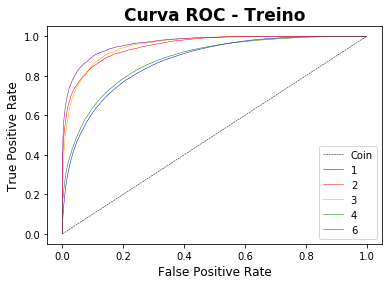

In [232]:
lr_fpr_0, lr_tpr_0, _ = roc_curve(np.asarray(pred_train['True 0']), np.asarray(pred_train['Mod 0']))
lr_fpr_1, lr_tpr_1, _ = roc_curve(np.asarray(pred_train['True 1']), np.asarray(pred_train['Mod 1']))
lr_fpr_2, lr_tpr_2, _ = roc_curve(np.asarray(pred_train['True 2']), np.asarray(pred_train['Mod 2']))
lr_fpr_3, lr_tpr_3, _ = roc_curve(np.asarray(pred_train['True 3']), np.asarray(pred_train['Mod 3']))
lr_fpr_4, lr_tpr_4, _ = roc_curve(np.asarray(pred_train['True 4']), np.asarray(pred_train['Mod 4']))
plt.plot([0.0, 1.0], [0.0, 1.0], 'r--', linewidth = 0.5, label = 'Coin', color = 'black')
plt.plot(lr_fpr_0, lr_tpr_0, linewidth = 0.5, label = '1', color = 'blue')
plt.plot(lr_fpr_1, lr_tpr_1, linewidth = 0.5, label = '2', color = 'red')
plt.plot(lr_fpr_2, lr_tpr_2, linewidth = 0.5, label = '3', color = 'orange')
plt.plot(lr_fpr_3, lr_tpr_3, linewidth = 0.5, label = '4', color = 'green')
plt.plot(lr_fpr_4, lr_tpr_4, linewidth = 0.5, label = '6', color = 'darkmagenta')
plt.title('Curva ROC - Treino', title_font)
plt.xlabel('False Positive Rate', axis_font)
plt.ylabel('True Positive Rate', axis_font)
plt.legend()

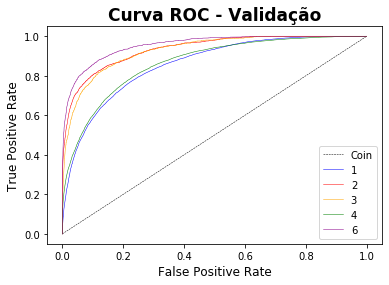

In [233]:
lr_fpr_0, lr_tpr_0, _ = roc_curve(np.asarray(pred_val['True 0']), np.asarray(pred_val['Mod 0']))
lr_fpr_1, lr_tpr_1, _ = roc_curve(np.asarray(pred_val['True 1']), np.asarray(pred_val['Mod 1']))
lr_fpr_2, lr_tpr_2, _ = roc_curve(np.asarray(pred_val['True 2']), np.asarray(pred_val['Mod 2']))
lr_fpr_3, lr_tpr_3, _ = roc_curve(np.asarray(pred_val['True 3']), np.asarray(pred_val['Mod 3']))
lr_fpr_4, lr_tpr_4, _ = roc_curve(np.asarray(pred_val['True 4']), np.asarray(pred_val['Mod 4']))
plt.plot([0.0, 1.0], [0.0, 1.0], 'r--', linewidth = 0.5, label = 'Coin', color = 'black')
plt.plot(lr_fpr_0, lr_tpr_0, linewidth = 0.5, label = '1', color = 'blue')
plt.plot(lr_fpr_1, lr_tpr_1, linewidth = 0.5, label = '2', color = 'red')
plt.plot(lr_fpr_2, lr_tpr_2, linewidth = 0.5, label = '3', color = 'orange')
plt.plot(lr_fpr_3, lr_tpr_3, linewidth = 0.5, label = '4', color = 'green')
plt.plot(lr_fpr_4, lr_tpr_4, linewidth = 0.5, label = '6', color = 'darkmagenta')
plt.title('Curva ROC - Validação', title_font)
plt.xlabel('False Positive Rate', axis_font)
plt.ylabel('True Positive Rate', axis_font)
plt.legend()

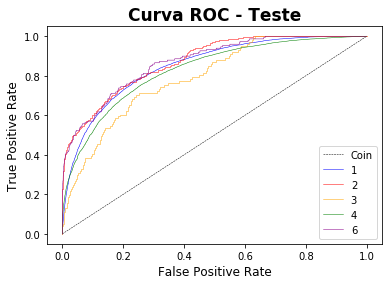

In [234]:
lr_fpr_0, lr_tpr_0, _ = roc_curve(np.asarray(pred_test['True 0']), np.asarray(pred_test['Mod 0']))
lr_fpr_1, lr_tpr_1, _ = roc_curve(np.asarray(pred_test['True 1']), np.asarray(pred_test['Mod 1']))
lr_fpr_2, lr_tpr_2, _ = roc_curve(np.asarray(pred_test['True 2']), np.asarray(pred_test['Mod 2']))
lr_fpr_3, lr_tpr_3, _ = roc_curve(np.asarray(pred_test['True 3']), np.asarray(pred_test['Mod 3']))
lr_fpr_4, lr_tpr_4, _ = roc_curve(np.asarray(pred_test['True 4']), np.asarray(pred_test['Mod 4']))
plt.plot([0.0, 1.0], [0.0, 1.0], 'r--', linewidth = 0.5, label = 'Coin', color = 'black')
plt.plot(lr_fpr_0, lr_tpr_0, linewidth = 0.5, label = '1', color = 'blue')
plt.plot(lr_fpr_1, lr_tpr_1, linewidth = 0.5, label = '2', color = 'red')
plt.plot(lr_fpr_2, lr_tpr_2, linewidth = 0.5, label = '3', color = 'orange')
plt.plot(lr_fpr_3, lr_tpr_3, linewidth = 0.5, label = '4', color = 'green')
plt.plot(lr_fpr_4, lr_tpr_4, linewidth = 0.5, label = '6', color = 'darkmagenta')
plt.title('Curva ROC - Teste', title_font)
plt.xlabel('False Positive Rate', axis_font)
plt.ylabel('True Positive Rate', axis_font)
plt.legend()